In [31]:
import sys
sys.path.append('..')

In [32]:
training_rootdir = '/group/jug/ashesh/training/diffsplit/'
ckpt = '2408/Hagen-sr3-l2/2'




ckpt = ckpt.strip('/').strip(' ')
ckpt

'2408/Hagen-sr3-l2/2'

In [33]:
import yaml
import os
import glob

def model_checkpoint_fpath(fname=None):
    ckpt_dir = os.path.join(training_rootdir, ckpt, 'checkpoint')
    if fname is not None:
        return os.path.join(training_rootdir, ckpt, fname)
    else:
        list_of_files = glob.glob(ckpt_dir +'/*_gen.pth') # * means all if need specific format then *.csv
        latest_file = max(list_of_files, key=os.path.getctime)
        fname = latest_file
        return os.path.join(ckpt_dir,latest_file)

def model_checkpoint_fpath_prefix(fname=None):
    fpath = model_checkpoint_fpath(fname)
    suffix = '_gen.pth'
    assert fpath.endswith(suffix)
    return fpath[:-len(suffix)]

def load_config(ckpt):
    config_path = os.path.join(training_rootdir,ckpt,'wandb/latest-run/files/config.yaml')

    with open(config_path) as stream:
        try:
            opt = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    
    keys = ["name","phase","gpu_ids","path","datasets","model","train","distributed"]
    return {k: opt[k]['value'] for k in keys}

In [34]:
opt = load_config(ckpt)
opt['path']['resume_state'] = model_checkpoint_fpath_prefix()
print(opt['path']['resume_state'])

/group/jug/ashesh/training/diffsplit/2408/Hagen-sr3-l2/2/checkpoint/I230000_E2875


In [35]:
opt['datasets']

{'train': {'name': 'Hagen',
  'patch_size': 512,
  'max_qval': 0.98,
  'datapath': {'ch0': '/group/jug/ashesh/data/ventura_gigascience_small/actin-60x-noise2-highsnr.tif',
   'ch1': '/group/jug/ashesh/data/ventura_gigascience_small/mito-60x-noise2-highsnr.tif'},
  'datatype': 'img',
  'batch_size': 4,
  'num_workers': 4,
  'use_shuffle': True},
 'val': {'name': 'Hagen',
  'patch_size': 512,
  'datapath': {'ch0': '/group/jug/ashesh/data/ventura_gigascience_small/actin-60x-noise2-highsnr.tif',
   'ch1': '/group/jug/ashesh/data/ventura_gigascience_small/mito-60x-noise2-highsnr.tif'},
  'datatype': 'img',
  'data_len': 3}}

In [39]:
import torch
import data as Data
import model as Model
from data.split_dataset import SplitDataset, DataLocation
# from tensorboardX import SummaryWriter
import os
# Convert to NoneDict, which return None for missing key.

# logging

patch_size = opt['datasets']['patch_size'] if 'patch_size' in opt['datasets'] else opt['datasets']['train']['patch_size']
target_channel_idx = opt['datasets']['target_channel_idx'] if 'target_channel_idx' in opt['datasets'] else None
upper_clip = opt['datasets'].get('upper_clip',False)
max_qval = opt['datasets'].get('max_qval', 0.98)

train_data_location = DataLocation(channelwise_fpath=(opt['datasets']['train']['datapath']['ch0'],
                                                opt['datasets']['train']['datapath']['ch1']))
train_set = SplitDataset(train_data_location, patch_size, target_channel_idx=target_channel_idx, 
                                max_qval=max_qval, upper_clip=upper_clip,
                             normalization_dict=None, enable_transforms=True,random_patching=True)


val_data_location = DataLocation(channelwise_fpath=(opt['datasets']['val']['datapath']['ch0'],
                                                    opt['datasets']['val']['datapath']['ch1']))
val_set = SplitDataset(val_data_location, patch_size, target_channel_idx=target_channel_idx,
                           normalization_dict=train_set.get_normalization_dict(),
                           max_qval=max_qval,
                            upper_clip=upper_clip,
                           enable_transforms=False,
                                                     random_patching=False)
# train_set = SplitDataset(train_data_location, patch_size, normalization_dict=None, enable_transforms=True,random_patching=True, upper_clip=)
# # train_loader = Data.create_dataloader(train_set, opt['datasets']['train'], 'train')

# patch_size = opt['datasets']['val']['patch_size']
# val_data_location = DataLocation(channelwise_fpath=(opt['datasets']['val']['datapath']['ch0'],
#                                                 opt['datasets']['val']['datapath']['ch1']))
# val_set = SplitDataset(val_data_location, patch_size, normalization_dict=train_set.get_normalization_dict(),
#                         enable_transforms=False,
#                                                     random_patching=False)
# val_loader = Data.create_dataloader(val_set, opt['datasets']['val'], 'val')
# model
diffusion = Model.create_model(opt)


diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule'][opt['phase']], schedule_phase=opt['phase'])

Computing mean and std for normalization


INFO:base:Initialization method [orthogonal]
INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2408/Hagen-sr3-l2/2/checkpoint/I230000_E2875] ...


[SplitDataset] Data: 20x2x(2048, 2048)               Patch:512 Random:1 Aug:True Q:0.98                 UpperClip:0
[SplitDataset] Data: 20x2x(2048, 2048)               Patch:512 Random:0 Aug:False Q:0.98                 UpperClip:0


INFO:base:Network G structure: GaussianDiffusion, with parameters: 2,438,770
INFO:base:GaussianDiffusion(
  (denoise_fn): UNet(
    (noise_level_mlp): Sequential(
      (0): PositionalEncoding()
      (1): Linear(in_features=16, out_features=64, bias=True)
      (2): Swish()
      (3): Linear(in_features=64, out_features=16, bias=True)
    )
    (downs): ModuleList(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ResnetBlocWithAttn(
        (res_block): ResnetBlock(
          (noise_func): FeatureWiseAffine(
            (noise_func): Sequential(
              (0): Linear(in_features=16, out_features=16, bias=True)
            )
          )
          (block1): Block(
            (block): Sequential(
              (0): GroupNorm(16, 16, eps=1e-05, affine=True)
              (1): Swish()
              (2): Identity()
              (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            )
          )
          (block2): Bloc

In [40]:
diffusion.load_network()

INFO:base:Loading pretrained model for G [/group/jug/ashesh/training/diffsplit/2408/Hagen-sr3-l2/2/checkpoint/I230000_E2875] ...


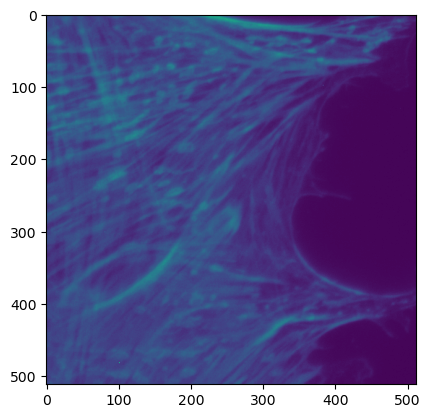

In [45]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0,len(val_set))
data = val_set[idx]
inp = data['input']
target = data['target']
diffusion_data = {'input': torch.Tensor(inp)[None].cuda(), 'target': torch.Tensor(target[None]).cuda()}
plt.imshow(inp[0])

In [46]:
diffusion.set_new_noise_schedule(
    opt['model']['beta_schedule']['val'], schedule_phase='val')
diffusion.feed_data(diffusion_data)
diffusion.test(continous=True, clip_denoised=True)
visuals = diffusion.get_current_visuals()
# input, target, prediction = unnormalize_data(visuals,train_set.get_normalization_dict())
input = visuals['input']
target = visuals['target']
prediction = visuals['prediction']


sampling loop time step: 100%|██████████| 2000/2000 [00:32<00:00, 62.03it/s]


In [47]:
target.shape

torch.Size([1, 2, 512, 512])

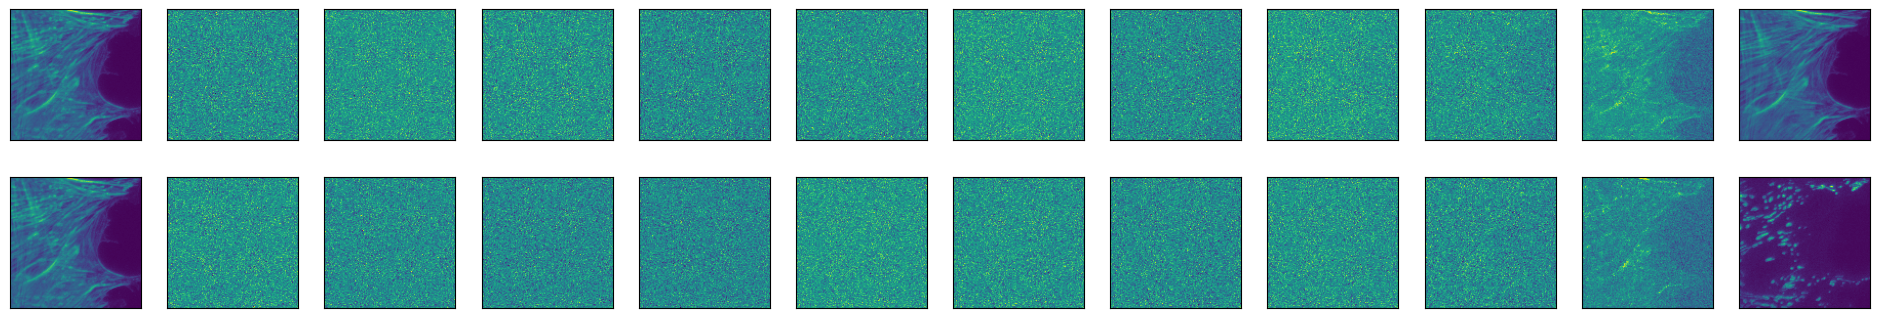

In [48]:
from disentangle.analysis.plot_utils import clean_ax
ncols = prediction.shape[0] + 1
nrows = 2
dfac = 4
_,ax = plt.subplots(figsize=(ncols*2,nrows*2), ncols=ncols, nrows=nrows)
for i in range(prediction.shape[0]):
    ax[0,i].imshow(prediction[i,0,::dfac,::dfac])
    ax[1,i].imshow(prediction[i,1,::dfac,::dfac])

ax[0,-1].imshow(target[0,0,::dfac,::dfac])
ax[1,-1].imshow(target[0,1,::dfac,::dfac])

clean_ax(ax)

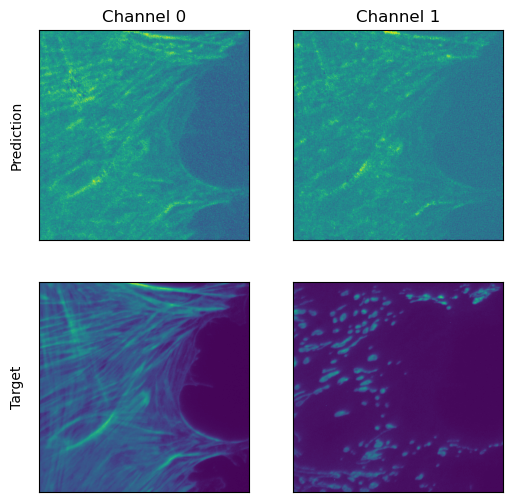

In [49]:
import matplotlib.pyplot as plt 
from disentangle.analysis.plot_utils import clean_ax
pred = prediction if len(prediction.shape) == 3 else prediction[-1]

_,ax = plt.subplots(figsize=(6,6),ncols=2,nrows=2)
ax[0,0].set_ylabel('Prediction')
ax[1,0].set_ylabel('Target')
ax[0,0].set_title('Channel 0')
ax[0,1].set_title('Channel 1')
ax[0,0].imshow(pred[0].cpu().numpy())
ax[1,0].imshow(target[0,0].cpu().numpy())

ax[0,1].imshow(pred[1].cpu().numpy())
ax[1,1].imshow(target[0,1].cpu().numpy())
clean_ax(ax)

In [ ]:
prediction[0].min(), prediction[0].max()

(tensor(-0.9951), tensor(1.))

In [55]:
prediction.shape

torch.Size([11, 2, 512, 512])

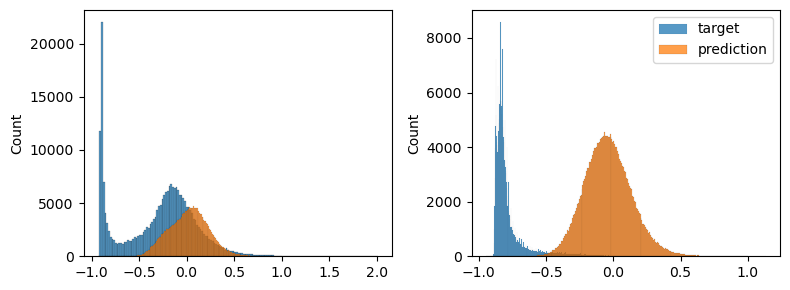

In [71]:
import seaborn as sns
_,ax = plt.subplots(figsize=(8,3),ncols=2)
for ch_idx in range(2):
    sns.histplot(target[0,ch_idx].reshape(-1,), label='target',ax=ax[ch_idx])
    sns.histplot(prediction[-1,ch_idx].reshape(-1,), label='prediction', ax=ax[ch_idx])
plt.legend()
plt.tight_layout()

In [57]:
norm_dict = val_set.get_normalization_dict()
norm_dict['mean_target'].shape

(2, 1, 1)

In [58]:
pred = prediction[-1] * norm_dict['std_target'] + norm_dict['mean_target']

In [59]:
pred.max()

tensor(2386.3400, dtype=torch.float64)

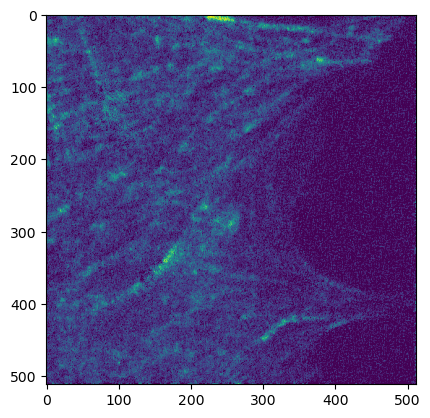

In [68]:
plt.imshow(pred[1], vmin=700)